In [1]:
!pip install -q transformers

     |████████████████████████████████| 4.7 MB 35.0 MB/s 
     |████████████████████████████████| 120 kB 63.5 MB/s 
     |████████████████████████████████| 6.6 MB 56.5 MB/s 


In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
device = torch.device("cuda")

In [3]:
df = pd.read_csv("/content/sample_data/Sentiment_analysis_data.csv")


In [4]:
df = df.sample(frac=1)

In [5]:
df.head()

,Comment,Tag
15634,বালের নাটক,0
688,জনগণের করের টাকায় বাজেট আর গৃহনির্মাণ খাতে জনগ...,2
22825,ওনেক সুন্দরর নাটক,1
7617,এক নম্বর ঠিক করলে বাকি দুইটা ঠিক হয়ে যাবে,2
2517,ফরম পূরণের আগে মন্ত্রণালয়ের উচিত মোট টাকার পরি...,1


In [ ]:
#df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
#df.replace(['Very Negative','Very Positive'],['Negative','Positive'],inplace=True)

In [ ]:
#df.replace(['Negative','Positive','Neutral'],[0,1,2],inplace=True)

In [11]:
df.replace([2],[1],inplace=True)

In [35]:
df.to_csv('Sentiment_Binary.csv')

In [13]:
df['Tag'].value_counts(normalize = True)

1    0.575608
0    0.424392
Name: Tag, dtype: float64

In [14]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Comment'], df['Tag'], 
                                                                    random_state=2018, 
                                                                    test_size=0.1, 
                                                                    stratify=df['Tag'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [15]:
bert = AutoModel.from_pretrained('sagorsarker/bangla-bert-base',return_dict=False)
tokenizer = BertTokenizerFast.from_pretrained('sagorsarker/bangla-bert-base')

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
token_lens = []

for txt in train_text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


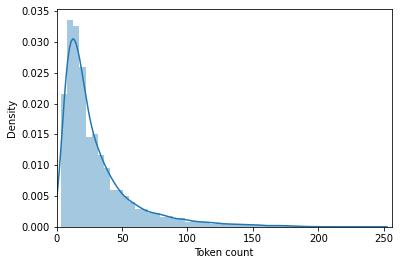

In [17]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

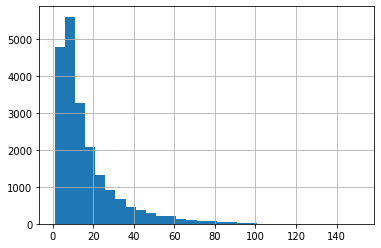

In [18]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [19]:
max_seq_len = 100

In [20]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [21]:

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())


val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())


test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [22]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [23]:
for param in bert.parameters():
    param.requires_grad = False

In [24]:
class BERT_Arch(nn.Module):

    def __init__(self, bert,freeze_bert=False):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert
      self.drop = nn.Dropout(p=0.3)
      self.out = nn.Linear(self.bert.config.hidden_size, 512) 
      self.out2 = nn.Linear(512, 2) 
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids,attention_mask):
      _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
       )
      output = self.drop(pooled_output)
      output = self.out(output)
      output = self.out2(output)

      return self.softmax(output)

In [25]:
model = BERT_Arch(bert)
model = model.to(device)

In [26]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [27]:
from sklearn.utils.class_weight import compute_class_weight
class_wts = compute_class_weight(class_weight = "balanced", classes= np.unique(train_labels), y= train_labels)
print(class_wts)

[1.17818057 0.86863338]


In [28]:
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

In [29]:
cross_entropy  = nn.NLLLoss(weight=weights) 
epochs = 5

In [30]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  total_preds=[]

  for step,batch in enumerate(train_dataloader):
    

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    model.zero_grad()        

  
    preds = model(sent_id, mask)

 
    loss = cross_entropy(preds, labels)

    total_loss = total_loss + loss.item()


    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    preds=preds.detach().cpu().numpy()

    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)

  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [31]:
def evaluate():
  
  print("\nEvaluating...")

  model.eval()

  total_loss, total_accuracy = 0, 0
  
 
  total_preds = []

  
  for step,batch in enumerate(val_dataloader):
    
    
    if step % 50 == 0 and not step == 0:
      
    
            
      
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    
    with torch.no_grad():
      
    
      preds = model(sent_id, mask)

      
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

 
  avg_loss = total_loss / len(val_dataloader) 

  
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [32]:
best_valid_loss = float('inf')


train_losses=[]
valid_losses=[]


for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
  
    train_loss, _ = train()
    
  
    valid_loss, _ = evaluate()
    
  
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
  
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    646.
  Batch   100  of    646.
  Batch   150  of    646.
  Batch   200  of    646.
  Batch   250  of    646.
  Batch   300  of    646.
  Batch   350  of    646.
  Batch   400  of    646.
  Batch   450  of    646.
  Batch   500  of    646.
  Batch   550  of    646.
  Batch   600  of    646.

Evaluating...

Training Loss: 0.609
Validation Loss: 0.602

 Epoch 2 / 5
  Batch    50  of    646.
  Batch   100  of    646.
  Batch   150  of    646.
  Batch   200  of    646.
  Batch   250  of    646.
  Batch   300  of    646.
  Batch   350  of    646.
  Batch   400  of    646.
  Batch   450  of    646.
  Batch   500  of    646.
  Batch   550  of    646.
  Batch   600  of    646.

Evaluating...

Training Loss: 0.596
Validation Loss: 0.581

 Epoch 3 / 5
  Batch    50  of    646.
  Batch   100  of    646.
  Batch   150  of    646.
  Batch   200  of    646.
  Batch   250  of    646.
  Batch   300  of    646.
  Batch   350  of    646.
  Batch   400  of    646.
  Batc

In [33]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [34]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.59      0.92      0.71       488
           1       0.89      0.52      0.66       661

    accuracy                           0.69      1149
   macro avg       0.74      0.72      0.69      1149
weighted avg       0.76      0.69      0.68      1149



In [ ]:
pd.crosstab(test_y, preds)

col_0,0,1,2
row_0,,,
0,328,58,102
1,110,331,73
2,69,18,60
